# Counterfactual analysis (run_cf)


## 1. Setup
Core libraries used throughout the notebook.

In [1]:
### Import libraries

import numpy as np
import pandas as pd
import dataclasses
from functools import partial
from typing import Callable
from typing import Tuple
import itertools
import pyblp
import linearmodels


## 2. Load product and agent data
Inputs are already cleaned in `get_elas_div.ipynb`.

In [2]:
# Import data (already cleaned and standardized in get_elas_div.ipynb)
# Note: prices/size/mpg/hp/weight are already scaled; do NOT rescale here.
product_data = pd.read_csv('data/raw/product_data.csv')
agent_data = pd.read_csv('data/raw/agent_data.csv')


## 3. Load estimation results
Load the `pyblp` results object used for all counterfactuals.

In [3]:
import pickle

# Load the results object from the file under a new name
import json
from pathlib import Path

cfg_path = Path("results_config.json")
if not cfg_path.exists():
    cfg_path = Path("post_est") / "results_config.json"
cfg = json.loads(cfg_path.read_text())
results_path = Path(cfg["results_file"])
if not results_path.is_absolute():
    results_path = (cfg_path.parent / results_path).resolve()

with open(results_path, "rb") as f:
    results = pickle.load(f)


## 4. Prepare costs and panel data
Attach the cost and panel inputs required for tariff counterfactuals.

In [4]:
from helpers.counterfactual_costs_prep import prepare_costs_df2_for_year

product_data, rho_data, costs_df2, diag = prepare_costs_df2_for_year(
    product_data=product_data,
    vehicle_costs_csv="data/derived/vehicle_costs_markups_chars.csv",
    pc_panel_csv="data/raw/pc_data_panel.csv",
    year=2024,
)

pc_panel_data = rho_data  # if you want the alias
print(diag)


{'filled_from_make_model': 0, 'filled_from_firm_mean': 19, 'remaining_missing_us_pcUSCA_pct': 5}


## 5. Load counterfactual helpers
Reload helper modules during development so notebook uses the latest code.

In [5]:
import importlib
from helpers import counterfactual_helpers
importlib.reload(counterfactual_helpers)
from helpers.counterfactual_helpers import (
    run_unified_counterfactual,
    origin_percent_metrics,
    plot_origin_percent_metrics_bw
)


## 6. Counterfactual configuration
Set indices that locate price terms and define tariff parameters.

In [6]:
# Define indicies
# Indices for price terms in your model
PRICE_X2_INDEX = 1   # column of prices in products.X2
PRICE_BETA_INDEX = 0  # index of mean price coef in results.beta
CS_GAMMA = 0.0  # outside good utility normalization
INCOME_DEMO_INDEX = 0  # income column in agents.demographics
INCOME_TRANSFORM = "log_10k"  # log income in 10k units -> dollars
REGION_START_INDEX = 1  # first region dummy column in demographics
REGION_LABELS = [
    "North East",
    "North Central",
    "South Atlantic",
    "South Central",
    "Mountain",
    "Pacific",
]
CS_MARKET_ID = 2024    # market id for CS diagnostics (use "2024" if ids are strings)

COUNTRY_TARIFFS = {
    "United Kingdom": 0.10,
    "Japan": 0.15,
    "South Korea": 0.15,
}

PARTS_TARIFF = 0.25
VEHICLE_TARIFF = 0.25


## 6.1 State map helpers
Used by the assembly and consumer surplus maps.

In [7]:
STATE_ABBR = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY",
}

STATE_CENTROIDS = {
    "AL": (32.806671, -86.791130), "AK": (61.370716, -152.404419),
    "AZ": (33.729759, -111.431221), "AR": (34.969704, -92.373123),
    "CA": (36.116203, -119.681564), "CO": (39.059811, -105.311104),
    "CT": (41.597782, -72.755371), "DE": (39.318523, -75.507141),
    "FL": (27.766279, -81.686783), "GA": (33.040619, -83.643074),
    "HI": (21.094318, -157.498337), "ID": (44.240459, -114.478828),
    "IL": (40.349457, -88.986137), "IN": (39.849426, -86.258278),
    "IA": (42.011539, -93.210526), "KS": (38.526600, -96.726486),
    "KY": (37.668140, -84.670067), "LA": (31.169546, -91.867805),
    "ME": (44.693947, -69.381927), "MD": (39.063946, -76.802101),
    "MA": (42.230171, -71.530106), "MI": (43.326618, -84.536095),
    "MN": (45.694454, -93.900192), "MS": (32.741646, -89.678696),
    "MO": (38.456085, -92.288368), "MT": (46.921925, -110.454353),
    "NE": (41.125370, -98.268082), "NV": (38.313515, -117.055374),
    "NH": (43.452492, -71.563896), "NJ": (40.298904, -74.521011),
    "NM": (34.840515, -106.248482), "NY": (42.165726, -74.948051),
    "NC": (35.630066, -79.806419), "ND": (47.528912, -99.784012),
    "OH": (40.388783, -82.764915), "OK": (35.565342, -96.928917),
    "OR": (44.572021, -122.070938), "PA": (40.590752, -77.209755),
    "RI": (41.680893, -71.511780), "SC": (33.856892, -80.945007),
    "SD": (44.299782, -99.438828), "TN": (35.747845, -86.692345),
    "TX": (31.054487, -97.563461), "UT": (40.150032, -111.862434),
    "VT": (44.045876, -72.710686), "VA": (37.769337, -78.169968),
    "WA": (47.400902, -121.490494), "WV": (38.491226, -80.954453),
    "WI": (44.268543, -89.616508), "WY": (42.755966, -107.302490),
}


## 7. Define scenarios and run counterfactuals
Build the scenario set and run the unified counterfactual pipeline.

In [32]:
import importlib
from helpers import counterfactual_helpers, counterfactual_reporting, consumer_surplus
importlib.reload(counterfactual_helpers)
importlib.reload(counterfactual_reporting)
importlib.reload(consumer_surplus)

from helpers.counterfactual_reporting import (
    default_scenario_specs,
    run_scenario_outputs,
    build_state_cs_table,
    build_state_cs_map_figure,
)

In [ ]:


agent_cf = pd.read_csv("data/raw/agent_data_cf.csv")

specs = default_scenario_specs(
    parts_tariff=PARTS_TARIFF,
    vehicle_tariff=VEHICLE_TARIFF,
    country_tariffs=COUNTRY_TARIFFS,
)

outs = run_scenario_outputs(
    results,
    product_data,
    costs_df2,
    agent_data=agent_data,
    year=2024,
    price_x2_index=PRICE_X2_INDEX,
    beta_price_index=PRICE_BETA_INDEX,
    gamma=CS_GAMMA,
    specs=specs,
)


Initializing the simulation ...
Initialized the simulation after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    D 
---  ----  ---  -----  ----  ----  ---
10   2982  40   24000   95    12    7 

Formulations:
       Column Indices:               0                1               2             3              4            5         6            7                 8                 9                 10                11                12                13                14                15                   16                       17                       18                       19                       20                       21                       22                       23                       24              25           26                   27                   28                   29                   30                   31                   32                   33                   34            35      36                37                        38               

## 8. Full scenario outputs
Generates all tables/figures for Sections 6–7 and Appendices C/D in one pass.


Scenario: parts and vehicles tariff (with subsidy)


,ΔPrice (%),ΔCost (%),ΔMarkup (pp),ΔShare (pp)
origin,,,,
Foreign-assembled,+12.26,+14.93,-1.84,-3.94
US-assembled,+8.31,+9.51,-0.91,-0.10


,scenario,total_units_millions,total_value_usd_billions
0,base,11.369262,364.265693
1,counterfactual,10.479278,351.964084


,Panel,Firm,Δ Profit (millions USD),%Δ
0,Panel A. Largest Increases,honda,+450.5,+11.3
1,Panel A. Largest Increases,tesla,+374.2,+11.8
2,Panel A. Largest Increases,toyota,+319.7,+3.5
3,Panel A. Largest Increases,jeep,+126.2,+5.0
4,Panel A. Largest Increases,acura,+121.5,+26.0
5,Panel B. Largest Decreases,ford,-1322.5,-19.0
6,Panel B. Largest Decreases,mercedesbenz,-519.1,-50.1
7,Panel B. Largest Decreases,chevrolet,-512.3,-7.5
8,Panel B. Largest Decreases,bmw,-393.8,-31.0
9,Panel B. Largest Decreases,hyundai,-370.6,-12.4


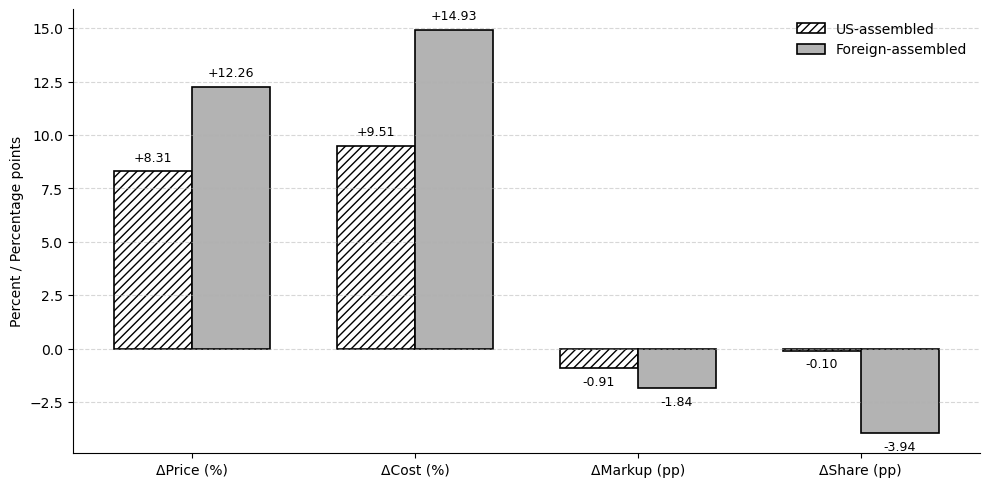

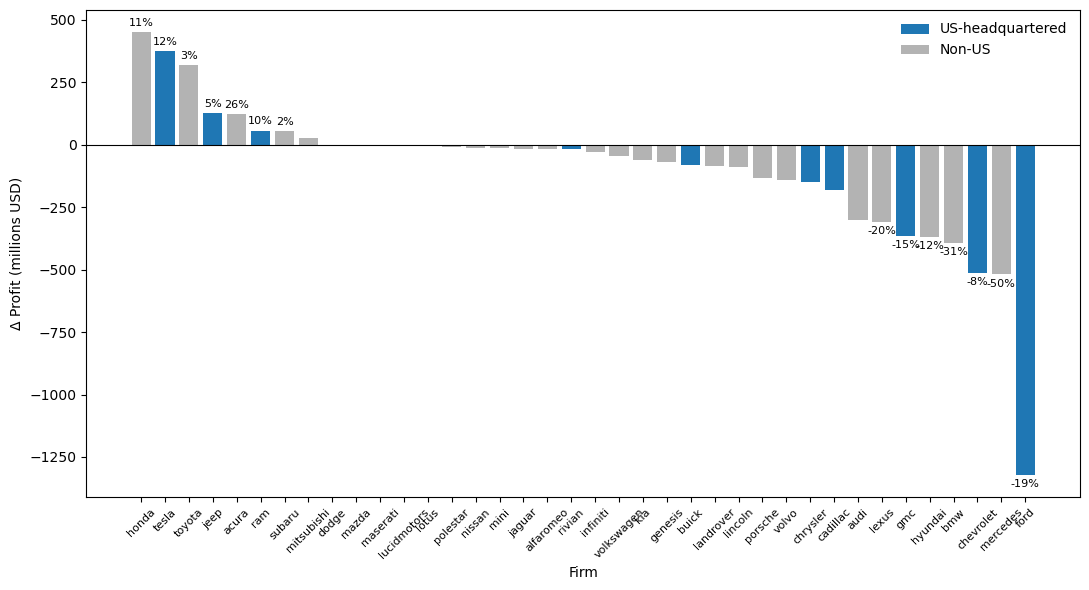

/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/2853352259.py:164: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.


/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/2853352259.py:196: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.





Scenario: vehicles-only tariff (with subsidy)


,ΔPrice (%),ΔCost (%),ΔMarkup (pp),ΔShare (pp)
origin,,,,
Foreign-assembled,+12.10,+14.93,-1.95,-7.77
US-assembled,+0.26,-0.00,+0.21,+5.85


,scenario,total_units_millions,total_value_usd_billions
0,base,11.369262,364.265693
1,counterfactual,10.946878,360.085453


,Panel,Firm,Δ Profit (millions USD),%Δ
0,Panel A. Largest Increases,tesla,+607.3,+19.2
1,Panel A. Largest Increases,honda,+482.4,+12.1
2,Panel A. Largest Increases,jeep,+307.5,+12.1
3,Panel A. Largest Increases,nissan,+290.9,+9.2
4,Panel A. Largest Increases,cadillac,+262.7,+39.7
5,Panel B. Largest Decreases,mercedesbenz,-664.3,-64.1
6,Panel B. Largest Decreases,toyota,-531.4,-5.8
7,Panel B. Largest Decreases,audi,-428.6,-53.4
8,Panel B. Largest Decreases,lexus,-415.5,-27.1
9,Panel B. Largest Decreases,hyundai,-413.2,-13.8


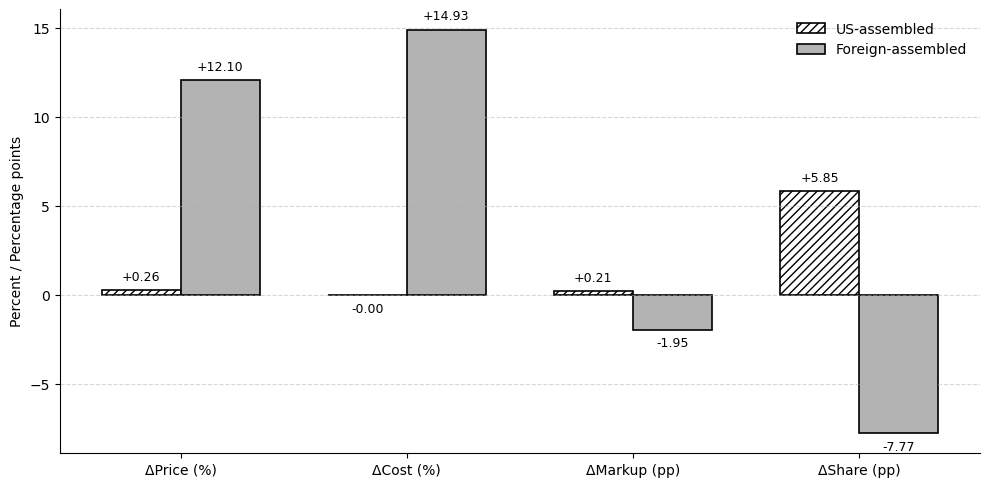

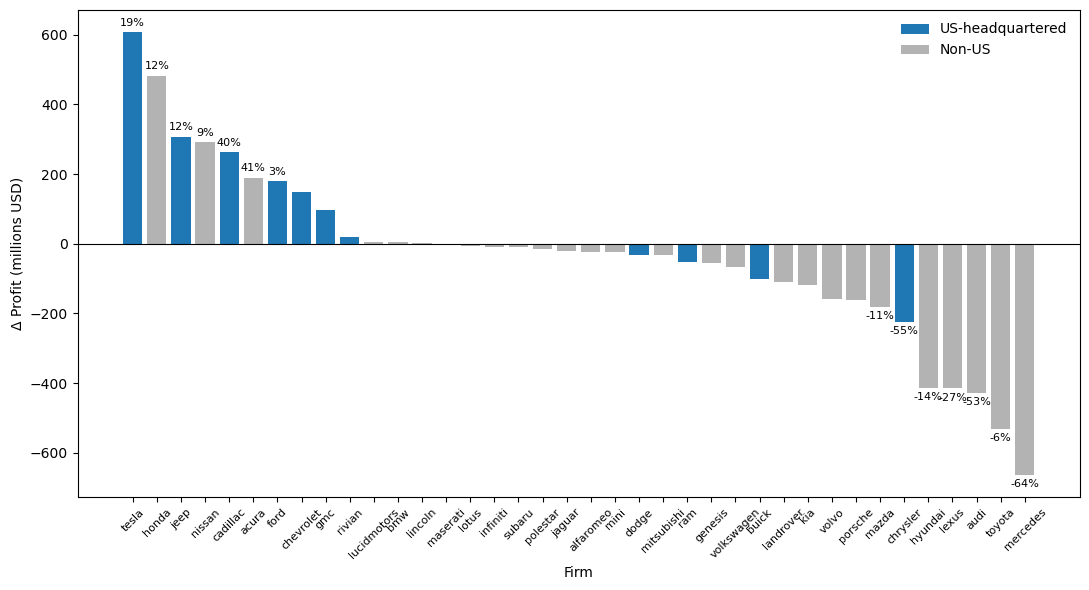

/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/2853352259.py:164: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.


/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/2853352259.py:196: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.





Scenario: parts and vehicles tariff (no subsidy)


,ΔPrice (%),ΔCost (%),ΔMarkup (pp),ΔShare (pp)
origin,,,,
Foreign-assembled,+12.29,+14.93,-1.82,-3.56
US-assembled,+8.18,+9.51,-1.01,-1.05


,scenario,total_units_millions,total_value_usd_billions
0,base,11.369262,364.265693
1,counterfactual,10.353596,347.768443


,Panel,Firm,Δ Profit (millions USD),%Δ
0,Panel A. Largest Increases,toyota,+529.7,+5.7
1,Panel A. Largest Increases,honda,+509.2,+12.7
2,Panel A. Largest Increases,acura,+128.5,+27.5
3,Panel A. Largest Increases,subaru,+66.6,+2.6
4,Panel A. Largest Increases,ram,+60.7,+10.8
5,Panel B. Largest Decreases,tesla,-1702.7,-53.8
6,Panel B. Largest Decreases,ford,-1292.3,-18.6
7,Panel B. Largest Decreases,mercedesbenz,-487.0,-47.0
8,Panel B. Largest Decreases,chevrolet,-444.9,-6.5
9,Panel B. Largest Decreases,bmw,-342.6,-27.0


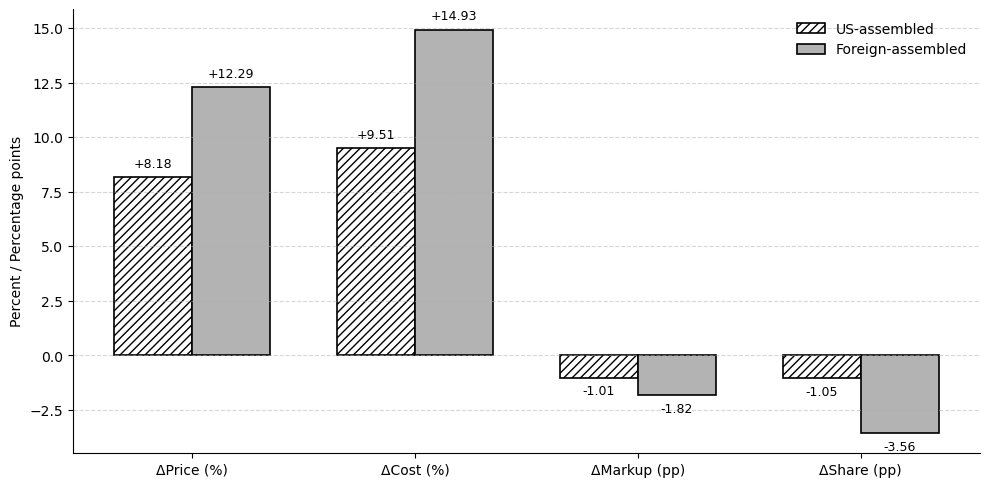

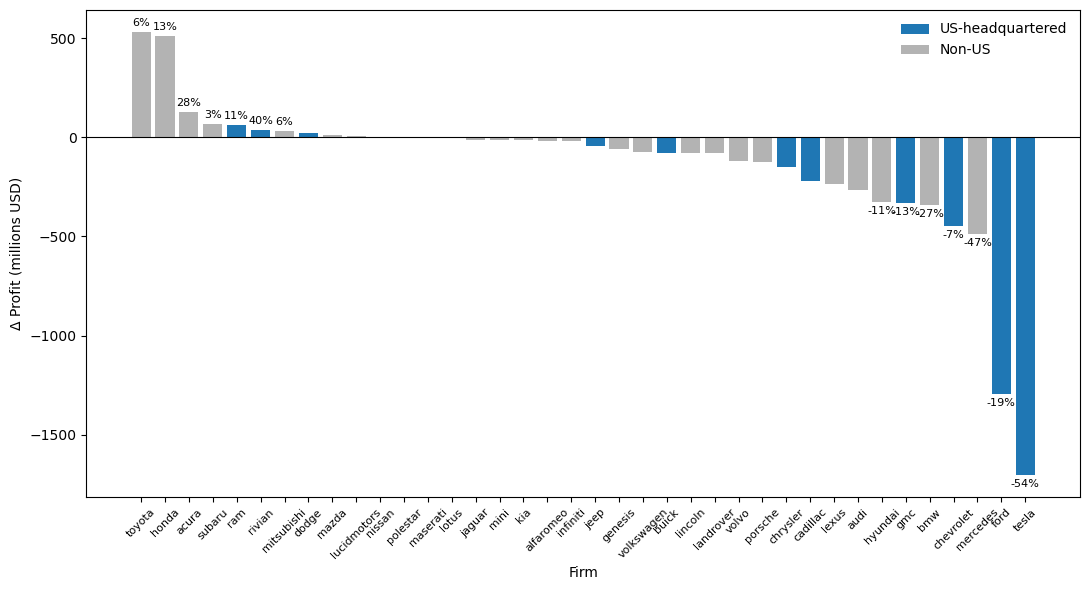

/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/2853352259.py:164: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.


/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/2853352259.py:196: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.





Scenario: vehicles-only tariff (no subsidy)


,ΔPrice (%),ΔCost (%),ΔMarkup (pp),ΔShare (pp)
origin,,,,
Foreign-assembled,+12.13,+14.93,-1.93,-7.43
US-assembled,+0.10,-0.00,+0.09,+4.85


,scenario,total_units_millions,total_value_usd_billions
0,base,11.369262,364.265693
1,counterfactual,10.799642,355.336711


,Panel,Firm,Δ Profit (millions USD),%Δ
0,Panel A. Largest Increases,honda,+552.5,+13.8
1,Panel A. Largest Increases,nissan,+298.3,+9.4
2,Panel A. Largest Increases,chevrolet,+228.0,+3.3
3,Panel A. Largest Increases,ford,+214.7,+3.1
4,Panel A. Largest Increases,acura,+196.1,+42.0
5,Panel B. Largest Decreases,tesla,-1615.1,-51.0
6,Panel B. Largest Decreases,mercedesbenz,-640.4,-61.8
7,Panel B. Largest Decreases,audi,-402.1,-50.1
8,Panel B. Largest Decreases,hyundai,-366.1,-12.2
9,Panel B. Largest Decreases,lexus,-334.8,-21.9


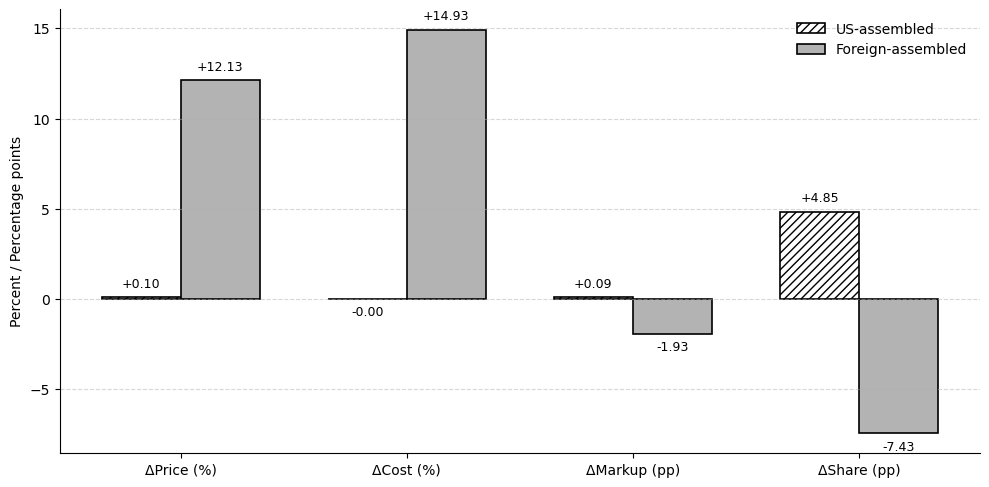

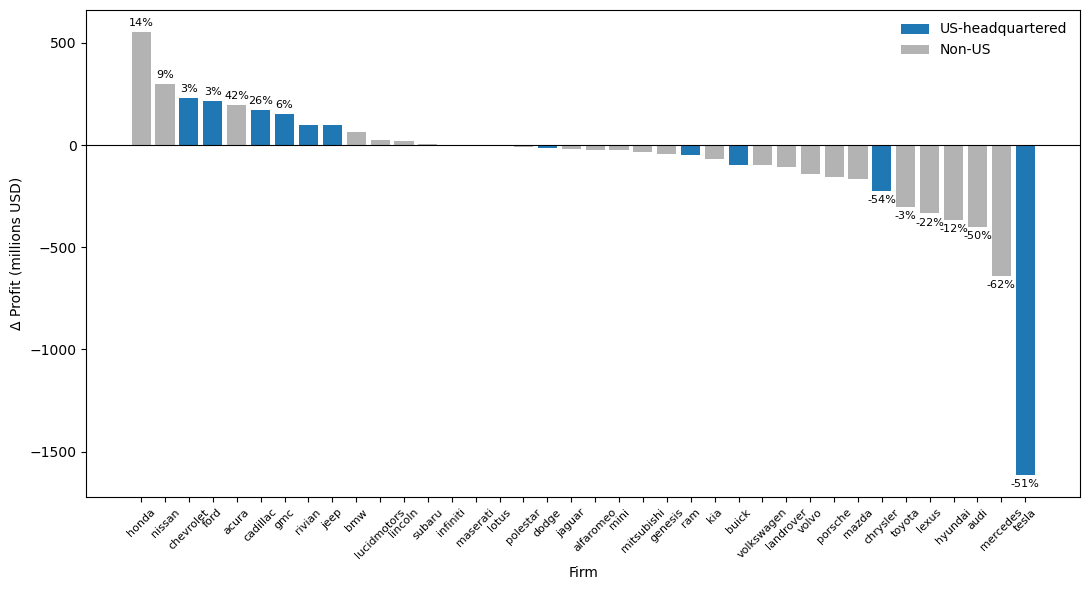

/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/2853352259.py:164: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.


/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/2853352259.py:196: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.





Scenario: no tariff (with subsidy)


,ΔPrice (%),ΔCost (%),ΔMarkup (pp),ΔShare (pp)
origin,,,,
Foreign-assembled,+0.00,+0.00,+0.00,-0.00
US-assembled,-0.00,+0.00,-0.00,+0.00


,scenario,total_units_millions,total_value_usd_billions
0,base,11.369262,364.265693
1,counterfactual,11.369262,364.265693


,Panel,Firm,Δ Profit (millions USD),%Δ
0,Panel A. Largest Increases,tesla,+0.0,+0.0
1,Panel A. Largest Increases,toyota,+0.0,+0.0
2,Panel A. Largest Increases,lexus,+0.0,+0.0
3,Panel A. Largest Increases,bmw,+0.0,+0.0
4,Panel A. Largest Increases,mercedesbenz,+0.0,+0.0
5,Panel B. Largest Decreases,chevrolet,-0.0,-0.0
6,Panel B. Largest Decreases,ford,-0.0,-0.0
7,Panel B. Largest Decreases,gmc,-0.0,-0.0
8,Panel B. Largest Decreases,ram,-0.0,-0.0
9,Panel B. Largest Decreases,nissan,-0.0,-0.0


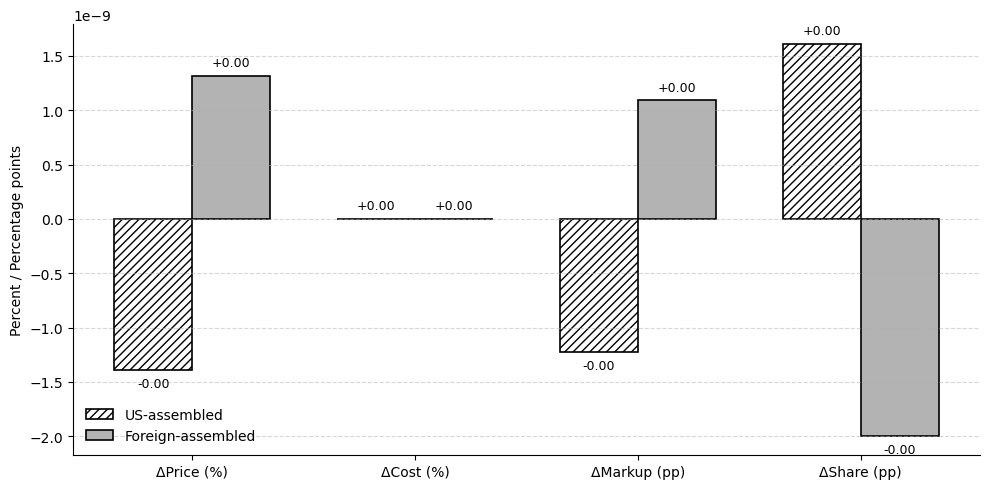

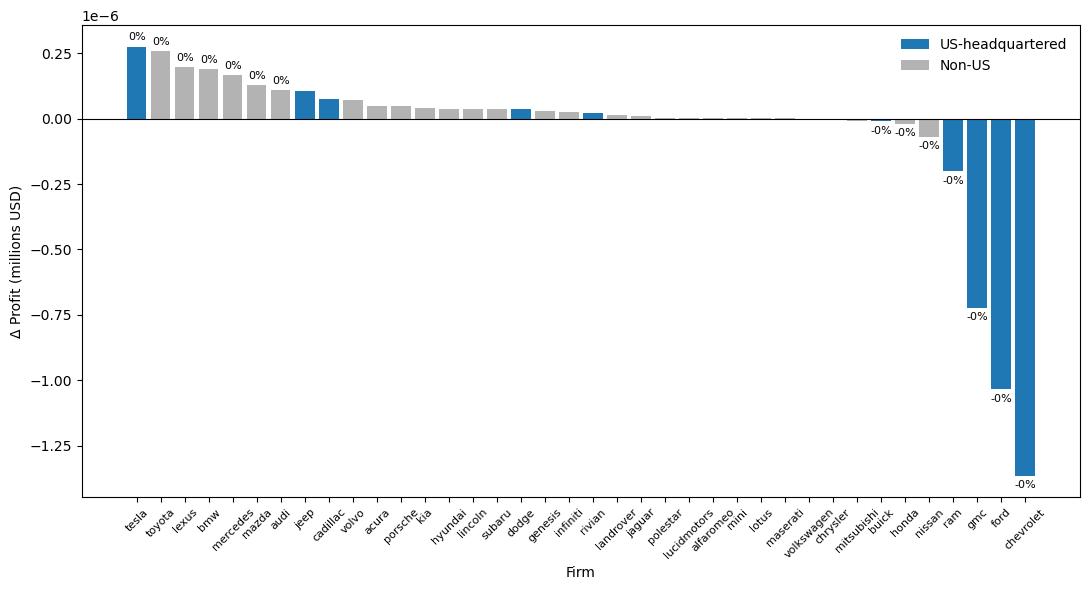

/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/2853352259.py:164: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.


/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/2853352259.py:196: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.





Scenario: no tariff (no subsidy)


,ΔPrice (%),ΔCost (%),ΔMarkup (pp),ΔShare (pp)
origin,,,,
Foreign-assembled,+0.03,+0.00,+0.02,+0.50
US-assembled,-0.17,+0.00,-0.14,-1.06


,scenario,total_units_millions,total_value_usd_billions
0,base,11.369262,364.265693
1,counterfactual,11.245622,360.415081


,Panel,Firm,Δ Profit (millions USD),%Δ
0,Panel A. Largest Increases,toyota,+191.3,+2.1
1,Panel A. Largest Increases,lexus,+87.1,+5.7
2,Panel A. Largest Increases,bmw,+72.5,+5.7
3,Panel A. Largest Increases,chevrolet,+62.9,+0.9
4,Panel A. Largest Increases,rivian,+61.8,+64.3
5,Panel B. Largest Decreases,tesla,-1955.1,-61.7
6,Panel B. Largest Decreases,jeep,-184.5,-7.3
7,Panel B. Largest Decreases,cadillac,-78.7,-11.9
8,Panel B. Largest Decreases,volkswagen,-23.0,-1.3
9,Panel B. Largest Decreases,acura,-1.8,-0.4


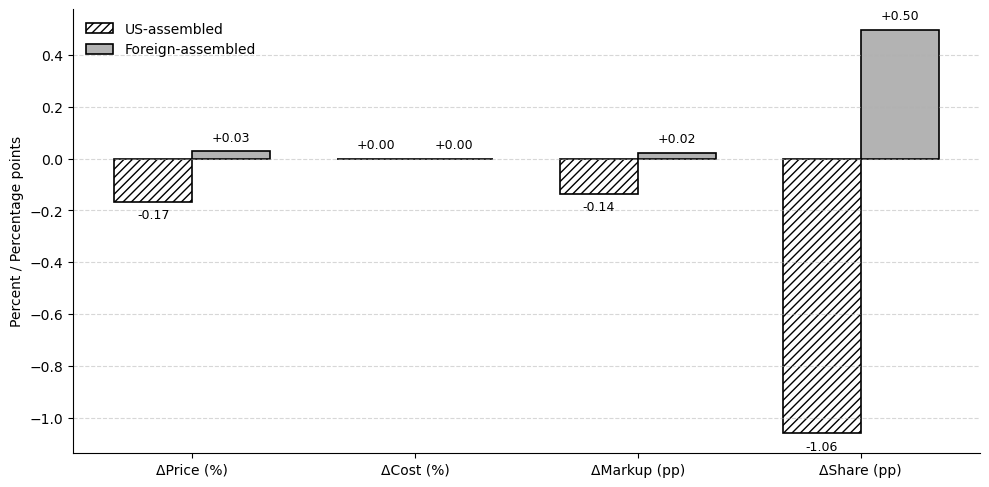

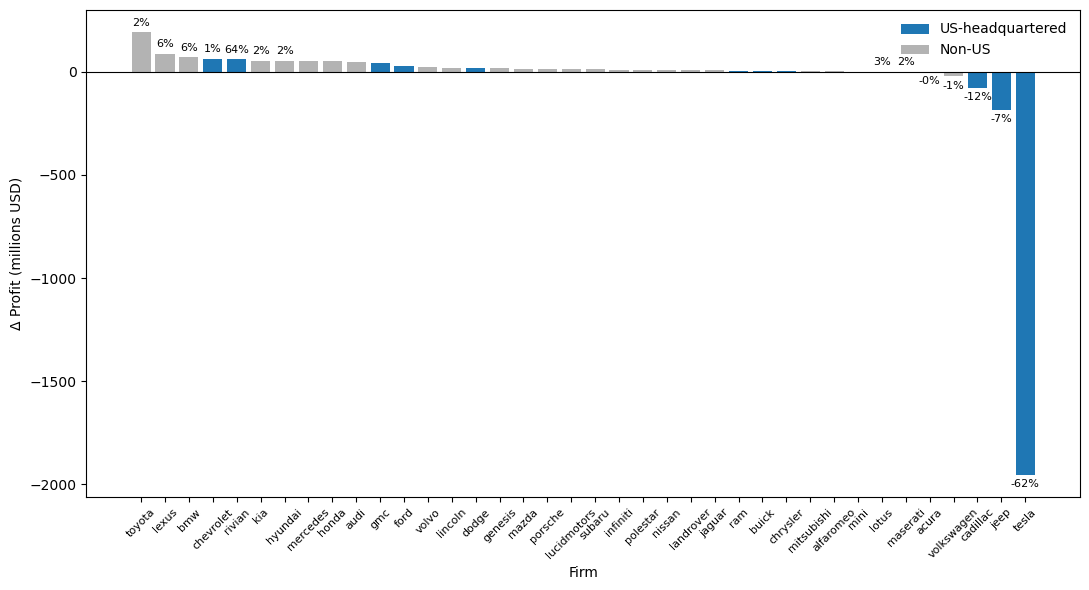

/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/2853352259.py:164: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.


/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/2853352259.py:196: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




Scenario,parts and vehicles tariff (with subsidy),parts and vehicles tariff (no subsidy),vehicles-only tariff (with subsidy),vehicles-only tariff (no subsidy),no tariff (no subsidy),no tariff (with subsidy)
Sales-weighted Δ Price (%),10.143788,10.089799,5.761392,5.694323,-0.076081,-0.0
"Sales-weighted Markup (CF, %)",17.388921,17.246926,17.633472,17.478291,18.022938,18.138248
"US Producer Surplus (Δ, billion USD)",-2.074502,-4.139037,1.211325,-1.035331,-1.999408,-0.0
CS Δ total (billion USD),-33.829 (-9.7%),-36.363 (-10.5%),-15.119 (-4.4%),-18.029 (-5.2%),-2.464 (-0.7%),0.000 (0.0%)
CS Δ Q1 (billion USD),-1.278 (-14.8%),-1.319 (-15.3%),-0.516 (-6.0%),-0.572 (-6.6%),-0.060 (-0.7%),0.000 (0.0%)
CS Δ Q2 (billion USD),-3.492 (-15.5%),-3.671 (-16.3%),-1.741 (-7.7%),-1.999 (-8.9%),-0.254 (-1.1%),0.000 (0.0%)
CS Δ Q3 (billion USD),-6.008 (-13.8%),-6.475 (-14.9%),-2.654 (-6.1%),-3.234 (-7.4%),-0.522 (-1.2%),0.000 (0.0%)
CS Δ Q4 (billion USD),-9.433 (-11.6%),-10.107 (-12.4%),-3.900 (-4.8%),-4.646 (-5.7%),-0.644 (-0.8%),0.000 (0.0%)
CS Δ Q5 (billion USD),-13.617 (-7.1%),-14.791 (-7.7%),-6.308 (-3.3%),-7.578 (-4.0%),-0.985 (-0.5%),-0.000 (-0.0%)
Δ vehicles sold (millions),-0.889984,-1.015666,-0.422384,-0.56962,-0.12364,-0.0


parts and vehicles tariff (with subsidy)  \
plant_location                                                         
Alabama        % change                                    14.812445   
               Δ units (M)                                  0.077025   
Arizona        % change                                   -28.550252   
               Δ units (M)                                 -0.001179   
California     % change                                   -13.057207   
               Δ units (M)                                 -0.018431   
Georgia        % change                                    15.975060   
               Δ units (M)                                  0.038349   
Illinois       % change                                   -18.170712   
               Δ units (M)                                 -0.019363   
Indiana        % change                                     9.209509   
               Δ units (M)                                  0.055457   
Kansas         % change                                     6.087352   
               Δ units (M)                                  0.006345   
Kentucky       % change                                   -10.890321   
               Δ units (M)                                 -0.056717   
Michigan       % change                                    -7.061793   
               Δ units (M)                                 -0.105741   
Mississippi    % change                                    10.309372   
               Δ units (M)                                  0.007294   
Missouri       % change                                    -1.684638   
               Δ units (M)                                 -0.007513   
Ohio           % change                                    14.137777   
               Δ units (M)                                  0.071490   
South Carolina % change                                   -19.798734   
               Δ units (M)                                 -0.024323   
Tennessee      % change                                    -3.251156   
               Δ units (M)                                 -0.017336   
Texas          % change                                    -4.048823   
               Δ units (M)                                 -0.027053   

                            vehicles-only tariff (with subsidy)  \
plant_location                                                    
Alabama        % change                               31.282850   
               Δ units (M)                             0.162671   
Arizona        % change                               29.715919   
               Δ units (M)                             0.001227   
California     % change                               12.831630   
               Δ units (M)                             0.018113   
Georgia        % change                               29.161731   
               Δ units (M)                             0.070005   
Illinois       % change                               22.993521   
               Δ units (M)                             0.024503   
Indiana        % change                               27.785831   
               Δ units (M)                             0.167317   
Kansas         % change                               33.009143   
               Δ units (M)                             0.034407   
Kentucky       % change                               23.856871   
               Δ units (M)                             0.124247   
Michigan       % change                               11.650750   
               Δ units (M)                             0.174455   
Mississippi    % change                               13.916690   
               Δ units (M)                             0.009846   
Missouri       % change                               11.198173   
               Δ units (M)                             0.049943   
Ohio           % change                               25.281877   
               Δ units (M)                      

parts and vehicles tariff (with subsidy)  \
state                                                                  
ALABAMA       % change                                    -10.599688   
              Δ CS (B USD)                                -27.869188   
ALASKA        % change                                    -10.502005   
              Δ CS (B USD)                                -37.493030   
ARIZONA       % change                                    -10.810379   
...                                                              ...   
WEST VIRGINIA Δ CS (B USD)                                -26.430576   
WISCONSIN     % change                                    -10.365865   
              Δ CS (B USD)                                -34.597816   
WYOMING       % change                                    -10.648653   
              Δ CS (B USD)                                -31.979247   

                            vehicles-only tariff (with subsidy)  \
state                                                             
ALABAMA       % change                                -4.453434   
              Δ CS (B USD)                           -11.709174   
ALASKA        % change                                -5.060994   
              Δ CS (B USD)                           -18.068170   
ARIZONA       % change                                -4.895266   
...                                                         ...   
WEST VIRGINIA Δ CS (B USD)                           -11.765657   
WISCONSIN     % change                                -4.347682   
              Δ CS (B USD)                           -14.511120   
WYOMING       % change                                -4.651469   
              Δ CS (B USD)                           -13.968947   

                            parts and vehicles tariff (no subsidy)  \
state                                                                
ALABAMA       % change                                  -11.142978   
              Δ CS (B USD)                              -29.297632   
ALASKA        % change                                  -12.609913   
              Δ CS (B USD)                              -45.018436   
ARIZONA       % change                                  -11.903808   
...                                                            ...   
WEST VIRGINIA Δ CS (B USD)                              -28.849401   
WISCONSIN     % change                                  -10.893312   
              Δ CS (B USD)                              -36.358258   
WYOMING       % change                                  -11.463830   
              Δ CS (B USD)                              -34.427326   

                            vehicles-only tariff (no subsidy)  \
state                                                           
ALABAMA       % change                              -5.059917   
              Δ CS (B USD)                         -13.303767   
ALASKA        % change                              -7.480965   
              Δ CS (B USD)                         -26.707665   
ARIZONA       % change                              -6.125880   
...                                                       ...   
WEST VIRGINIA Δ CS (B USD)                         -14.478156   
WISCONSIN     % change                              -4.939916   
              Δ CS (B USD)                         -16.487800   
WYOMING       % change                              -5.560923   
              Δ CS (B USD)                         -16.700152   

                            no tariff (with subsidy)  no tariff (no subsidy)  
state                                                                         
ALABAMA       % change                  6.190783e-10               -0.526448  
              Δ CS (B USD)              1.627709e-09               -1.384161  
ALASKA        % change                 -3.554691e-10               -2.019559  
              Δ CS (B USD)             -1.269054e-09               

parts and vehicles tariff (with subsidy)  \
                                                                                                                  Δ   
(, Panel)                                          (, Outcome)                                                        
Panel A. Aggregate outcomes                        Producer Surplus                                         -3744.5   
                                                   Total Cars Sold (units)                                -889984.2   
Panel A2. Producer surplus by firm origin (mill... US firms                                                 -1439.5   
                                                   Non-US firms                                             -2304.9   
Panel B. Consumer surplus by income quintile (m... Q1                                                       -1278.3   
                                                   Q2                                                       -3590.9   
                                                   Q3                                                       -5953.7   
                                                   Q4                                                       -9388.3   
                                                   Q5                                                      -13617.5   

                                                                                   \
                                                                               %Δ   
(, Panel)                                          (, Outcome)                      
Panel A. Aggregate outcomes                        Producer Surplus          -6.2   
                                                   Total Cars Sold (units)   -7.8   
Panel A2. Producer surplus by firm origin (mill... US firms                  -4.7   
                                                   Non-US firms              -7.9   
Panel B. Consumer surplus by income quintile (m... Q1                       -14.8   
                                                   Q2                       -15.3   
                                                   Q3                       -13.8   
                                                   Q4                       -11.6   
                                                   Q5                        -7.1   

                                                                           vehicles-only tariff (with subsidy)  \
                                                                                                             Δ   
(, Panel)                                          (, Outcome)                                                   
Panel A. Aggregate outcomes                        Producer Surplus                                    -1267.7   
                                                   Total Cars Sold (units)                           -422383.8   
Panel A2. Producer surplus by firm origin (mill... US firms                                            +2592.1   
                                                   Non-US firms                                        -3859.7   
Panel B. Consumer surplus by income quintile (m... Q1                                                   -515.6   
                                                   Q2                                                  -1748.0   
                                                   Q3                                                  -2657.2   
                                                   Q4                                                  -3890.2   
                                                   Q5                                                  -6308.0   

                                                                                   \
                                                                               %Δ   
(, Panel)                                          (, Outcome)                      
P

In [182]:
# Full scenario outputs (Sections 6 & 7 + Appendices C/D)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import importlib
from helpers import counterfactual_helpers, counterfactual_reporting
importlib.reload(counterfactual_helpers)
importlib.reload(counterfactual_reporting)
from helpers.counterfactual_helpers import origin_percent_metrics, plot_origin_percent_metrics_bw

from helpers.counterfactual_profit_tables import profit_changes_table, profit_changes_table_latex
from helpers.consumer_surplus import cs_change_by_income_bins
from helpers.counterfactual_reporting import build_state_units_table, build_state_map_figure, build_state_cs_table, build_state_cs_map_figure
from helpers.ev_tariff_metrics import build_ev_and_tariff_table

TOTAL_MARKET_SIZE = 132_216_000 / 6
PRICE_SCALE_USD_PER_UNIT = 100_000.0

output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

def _slug(label):
    return "".join(ch.lower() if ch.isalnum() else "_" for ch in str(label)).strip("_")

# Ensure these are defined earlier in the notebook:
# specs, outs, PRICE_X2_INDEX, PRICE_BETA_INDEX, CS_GAMMA,
# INCOME_DEMO_INDEX, INCOME_TRANSFORM, REGION_START_INDEX, REGION_LABELS, CS_MARKET_ID

if "us_firms" not in globals():
    us_firms = [
        "ford", "chevrolet", "gmc", "buick", "cadillac", "chrysler",
        "ram", "jeep", "dodge", "tesla", "rivian", "lucid", "lincoln", "lucidmotors"
    ]

income_order = [f"Q{i}" for i in range(1, 6)]

# --- Appendix D: EV share + tariff revenue table for all scenarios ---
scenarios_for_ev = {}
for key, meta in outs.items():
    spec = specs[key]
    scenarios_for_ev[meta["label"]] = {
        "out": meta["out"],
        "vehicle_tariff": spec.vehicle_tariff,
        "parts_tariff": spec.parts_tariff,
        "country_tariffs": spec.country_tariffs,
    }

ev_tariff_tbl = build_ev_and_tariff_table(
    scenarios_for_ev,
    product_data=product_data,
    costs_df2=costs_df2,
    market_id=2024,
    total_market_size=TOTAL_MARKET_SIZE,
    price_scale_usd_per_unit=PRICE_SCALE_USD_PER_UNIT,
)

# --- Scenario loop ---
for key, meta in outs.items():
    label = meta["label"]
    out = meta["out"]
    product_tbl = out["product_table"]
    firm_tbl = out["firm_table"]

    print("\n" + "=" * 80)
    print(f"Scenario: {label}")
    print("=" * 80)

    # 6.1 Origin metrics
    metrics = origin_percent_metrics(product_tbl)
    display(metrics.style.format("{:+.2f}"))
    fig_origin = plot_origin_percent_metrics_bw(metrics, title="", show=False)
    fig_origin.savefig(os.path.join(output_dir, f"origin_metrics_{_slug(label)}.png"), dpi=200, bbox_inches="tight")

    # 6.2 Total sales levels (units and value)
    units_base = TOTAL_MARKET_SIZE * product_tbl["s0"].sum() / 1_000_000.0
    units_cf = TOTAL_MARKET_SIZE * product_tbl["s_cf"].sum() / 1_000_000.0

    value_base = TOTAL_MARKET_SIZE * (product_tbl["p0"] * product_tbl["s0"]).sum() * PRICE_SCALE_USD_PER_UNIT / 1_000_000_000.0
    value_cf = TOTAL_MARKET_SIZE * (product_tbl["p_cf"] * product_tbl["s_cf"]).sum() * PRICE_SCALE_USD_PER_UNIT / 1_000_000_000.0

    sales_summary = pd.DataFrame({
        "scenario": ["base", "counterfactual"],
        "total_units_millions": [units_base, units_cf],
        "total_value_usd_billions": [value_base, value_cf],
    })
    display(sales_summary)

    # 6.3 Firm-level profit changes
    tbl = profit_changes_table(firm_tbl, n=5)
    display(tbl)
    latex = profit_changes_table_latex(firm_tbl, n=5)
    # print(latex)

    plot_df = firm_tbl.copy()
    plot_df["firm_lower"] = plot_df["firm_ids"].astype(str).str.lower()
    us_set = {f.lower() for f in us_firms}
    plot_df["is_us"] = plot_df["firm_lower"].isin(us_set)
    plot_df = plot_df.sort_values("dpi_millions_usd", ascending=False)
    firm_labels = plot_df["firm_ids"].astype(str).replace({"mercedesbenz": "mercedes"})

    colors = ["tab:blue" if is_us else "0.7" for is_us in plot_df["is_us"]]

    fig, ax = plt.subplots(figsize=(11, 6))
    bars = ax.bar(firm_labels, plot_df["dpi_millions_usd"], color=colors)
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_title("")
    ax.set_ylabel("Δ Profit (millions USD)")
    ax.set_xlabel("Firm")
    ax.tick_params(axis="x", rotation=45, labelsize=8)

    # % change labels above/below bars
    pct_vals = 100.0 * plot_df["dpi_millions_usd"].to_numpy(dtype=float) / plot_df["pi0_millions_usd"].to_numpy(dtype=float)
    n = len(plot_df)
    label_mask = np.zeros(n, dtype=bool)
    label_mask[: min(7, n)] = True
    if n > 7:
        label_mask[max(n - 7, 0):] = True

    for rect, pct, keep in zip(bars, pct_vals, label_mask):
        if not keep or not np.isfinite(pct):
            continue
        y = rect.get_height()
        va = "bottom" if y >= 0 else "top"
        offset = 3 if y >= 0 else -3
        ax.annotate(
            f"{pct:.0f}%",
            (rect.get_x() + rect.get_width() / 2.0, y),
            xytext=(0, offset),
            textcoords="offset points",
            ha="center",
            va=va,
            fontsize=8,
            color="black",
        )

    from matplotlib.patches import Patch
    legend_handles = [
        Patch(facecolor="tab:blue", label="US-headquartered"),
        Patch(facecolor="0.7", label="Non-US"),
    ]
    ax.legend(handles=legend_handles, frameon=False, loc="upper right")
    plt.tight_layout()
    fig.savefig(os.path.join(output_dir, f"firm_profits_{_slug(label)}.png"), dpi=200, bbox_inches="tight")
    plt.show()

    # 6.4 US assembly by state (units) + map
    state_units = build_state_units_table(
        product_tbl,
        product_data,
        total_market_size=TOTAL_MARKET_SIZE,
    )
    if "STATE_ABBR" in globals() and "STATE_CENTROIDS" in globals():
        fig = build_state_map_figure(
            state_units,
            scenario_label=label,
            state_abbr=STATE_ABBR,
            state_centroids=STATE_CENTROIDS,
        )
        if fig is not None:
            fig.update_layout(title=None)
            try:
                fig.write_image(os.path.join(output_dir, f"assembly_map_{_slug(label)}.png"), scale=2, engine="kaleido")
            except Exception as exc:
                print(f"Assembly map PNG export skipped: {exc}")


    # Consumer surplus change map by state (computed here)
    if "agent_cf" in globals():
        cs_state_tbl = build_state_cs_table(
            out,
            agent_cf,
            results=results,
            market_id=CS_MARKET_ID,
            price_x2_index=PRICE_X2_INDEX,
            beta_price_index=PRICE_BETA_INDEX,
            income_col="log_income_10k",
            division_cols=["div1", "div2", "div3", "div4", "div5", "div6"],
            state_col="state",
            year_col="year",
            nodes_prefix="nodes",
            weight_col="weights",
            gamma=CS_GAMMA,
        )
        if "STATE_ABBR" in globals() and "STATE_CENTROIDS" in globals():
            cs_fig = build_state_cs_map_figure(
                cs_state_tbl,
                scenario_label=label,
                state_abbr=STATE_ABBR,
                state_centroids=STATE_CENTROIDS,
            )
            if cs_fig is not None:
                cs_fig.update_layout(title=None)
                try:
                    cs_fig.write_image(os.path.join(output_dir, f"cs_map_{_slug(label)}.png"), scale=2, engine="kaleido")
                except Exception as exc:
                    print(f"CS map PNG export skipped: {exc}")

    # 7.1 CS by income bins
    cs_tbl = cs_change_by_income_bins(
        results,
        product_tbl,
        market_id=CS_MARKET_ID,
        price_x2_index=PRICE_X2_INDEX,
        beta_price_index=PRICE_BETA_INDEX,
        income_demo_index=INCOME_DEMO_INDEX,
        income_transform=INCOME_TRANSFORM,
        n_bins=5,
        gamma=CS_GAMMA,
    )
    cs_income_table = (
        cs_tbl.rename(columns={"CS0": "cs0", "CS_cf": "cs_cf"})
              .assign(income_quintile=lambda d: d["bin"].map(lambda b: f"Q{int(b)}"))
    )
    # 7.2 Summary table (producer surplus + CS by income)

# --- Summary table across scenarios ---
summary_rows = []

# Map scenario label -> EV/tariff table row
_ev_map = {r["Scenario"]: r for _, r in ev_tariff_tbl.iterrows()}

for key, meta in outs.items():
    label = meta["label"]
    out = meta["out"]
    pt = out["product_table"]
    ft = out["firm_table"]

    w0 = pt["s0"].to_numpy(dtype=float)
    w0_sum = float(np.nansum(w0)) if np.isfinite(w0).any() else np.nan
    dp_sw = np.nan if w0_sum == 0 else float(np.nansum(pt["dp_pct"].to_numpy(dtype=float) * w0) / w0_sum)

    wcf = pt["s_cf"].to_numpy(dtype=float)
    wcf_sum = float(np.nansum(wcf)) if np.isfinite(wcf).any() else np.nan
    markup_sw = np.nan if wcf_sum == 0 else float(np.nansum(pt["margin_cf_pct"].to_numpy(dtype=float) * wcf) / wcf_sum)

    df_f = ft.copy()
    df_f["firm_lower"] = df_f["firm_ids"].astype(str).str.lower()
    us_set = {f.lower() for f in us_firms}
    us_mask = df_f["firm_lower"].isin(us_set)
    us_ps = float(df_f.loc[us_mask, "dpi_millions_usd"].sum()) / 1_000.0

    cs_tbl = cs_change_by_income_bins(
        results,
        pt,
        market_id=CS_MARKET_ID,
        price_x2_index=PRICE_X2_INDEX,
        beta_price_index=PRICE_BETA_INDEX,
        income_demo_index=INCOME_DEMO_INDEX,
        income_transform=INCOME_TRANSFORM,
        n_bins=5,
        gamma=CS_GAMMA,
    )
    cs_tbl = cs_tbl.rename(columns={"CS0": "cs0", "CS_cf": "cs_cf"})

    # Convert per-agent CS to totals (millions USD) using bin weights.
    cs_scale = float(TOTAL_MARKET_SIZE) * float(PRICE_SCALE_USD_PER_UNIT) / 1_000_000.0
    cs_tbl["cs0_total"] = cs_tbl["cs0"] * cs_tbl["weight_mass"] * cs_scale
    cs_tbl["cs_cf_total"] = cs_tbl["cs_cf"] * cs_tbl["weight_mass"] * cs_scale
    cs_tbl["dcs_total"] = cs_tbl["cs_cf_total"] - cs_tbl["cs0_total"]

    cs_total = float(cs_tbl["dcs_total"].sum()) / 1_000.0
    cs_total_pct = np.nan
    cs_base_total = float(cs_tbl["cs0_total"].sum()) / 1_000.0
    if cs_base_total != 0:
        cs_total_pct = 100.0 * cs_total / cs_base_total

    cs_quintile = {}
    for _, r in cs_tbl.iterrows():
        q = f"Q{int(r['bin'])}"
        d_cs = float(r["dcs_total"]) / 1_000.0
        pct = np.nan if r["cs0_total"] == 0 else 100.0 * d_cs / (float(r["cs0_total"]) / 1_000.0)
        cs_quintile[q] = f"{d_cs:.3f} ({pct:.1f}%)"

    # Totals and shares
    total_sold = float(TOTAL_MARKET_SIZE) * (float(np.nansum(pt["s_cf"].to_numpy(dtype=float))) - float(np.nansum(pt["s0"].to_numpy(dtype=float)))) / 1_000_000.0

    # avoid merge suffixes if plant_country already present
    pt = pt.drop(columns=[c for c in ["plant_country", "ev"] if c in pt.columns])
    cols = ["market_ids", "product_ids", "ev", "plant_country"]
    pd_map = product_data[cols].drop_duplicates(["market_ids", "product_ids"]).copy()
    m = pt.merge(pd_map, on=["market_ids", "product_ids"], how="left")
    if "plant_country" not in m.columns:
        raise KeyError("plant_country not found after merge; available columns: " + ",".join(m.columns))
    us_mask_prod = m["plant_country"].astype(str).str.strip().eq("United States")

    ev_share = float(np.nansum(m["s_cf"].to_numpy(dtype=float) * pd.to_numeric(m["ev"], errors="coerce").fillna(0.0).to_numpy(dtype=float)))
    ev_share = np.nan if np.nansum(m["s_cf"].to_numpy(dtype=float)) == 0 else 100.0 * ev_share / float(np.nansum(m["s_cf"].to_numpy(dtype=float)))

    us_share = float(np.nansum(m.loc[us_mask_prod, "s_cf"].to_numpy(dtype=float)))
    us_share = np.nan if np.nansum(m["s_cf"].to_numpy(dtype=float)) == 0 else us_share / float(np.nansum(m["s_cf"].to_numpy(dtype=float)))

    us_assembled = float(TOTAL_MARKET_SIZE) * (float(np.nansum(m.loc[us_mask_prod, "s_cf"].to_numpy(dtype=float))) - float(np.nansum(m.loc[us_mask_prod, "s0"].to_numpy(dtype=float)))) / 1_000_000.0

    rev_row = _ev_map.get(label, {})
    tariff_rev = float(rev_row.get("Tariff revenue – total (million USD)", np.nan)) / 1_000.0


    subsidy_spend = np.nan
    if "subsidy_cf" in pt.columns:
        sub_cf = pd.to_numeric(pt["subsidy_cf"], errors="coerce").to_numpy(dtype=float)
        subsidy_spend = float(TOTAL_MARKET_SIZE) * float(np.nansum(pt["s_cf"].to_numpy(dtype=float) * sub_cf))
        subsidy_spend = subsidy_spend * float(PRICE_SCALE_USD_PER_UNIT) / 1_000_000_000.0

    net_us_impact = us_ps + cs_total + tariff_rev - subsidy_spend + 3.96

    summary_rows.append({
        "Scenario": label,
        "Sales-weighted Δ Price (%)": dp_sw,
        "Sales-weighted Markup (CF, %)": markup_sw,
        "US Producer Surplus (Δ, billion USD)": us_ps,
        "CS Δ total (billion USD)": f"{cs_total:.3f} ({cs_total_pct:.1f}%)" if np.isfinite(cs_total_pct) else f"{cs_total:.3f} (nan)",
        "CS Δ Q1 (billion USD)": cs_quintile.get("Q1"),
        "CS Δ Q2 (billion USD)": cs_quintile.get("Q2"),
        "CS Δ Q3 (billion USD)": cs_quintile.get("Q3"),
        "CS Δ Q4 (billion USD)": cs_quintile.get("Q4"),
        "CS Δ Q5 (billion USD)": cs_quintile.get("Q5"),
        "Δ vehicles sold (millions)": total_sold,
        "EV share of vehicles sold (CF, %)": ev_share,
        "US share of vehicles sold (CF)": us_share,
        "Δ US assembled (millions)": us_assembled,
        "Tariff revenue (billion USD)": tariff_rev,
        "EV subsidy spending (billion USD)": subsidy_spend,
        "Net US impact (billion USD)": net_us_impact,
    })

summary_tbl_all = pd.DataFrame(summary_rows).set_index("Scenario").T

# Order scenarios: parts+vehicle tariffs, then vehicle-only, then no-tariff.
# Place no-tariff + no-subsidy as the second last column.
label_by_key = {k: v["label"] for k, v in outs.items()}
order_labels = []

# parts + vehicle tariffs
for subsidy_zero in (False, True):
    for k, spec in specs.items():
        if spec.parts_tariff > 0 and spec.vehicle_tariff > 0 and spec.subsidy_zero == subsidy_zero:
            order_labels.append(label_by_key[k])

# vehicle-only tariffs
for subsidy_zero in (False, True):
    for k, spec in specs.items():
        if spec.parts_tariff == 0 and spec.vehicle_tariff > 0 and spec.subsidy_zero == subsidy_zero:
            order_labels.append(label_by_key[k])

# no-tariff scenarios: put subsidy-off second last, subsidy-on last
for subsidy_zero in (True, False):
    for k, spec in specs.items():
        if spec.parts_tariff == 0 and spec.vehicle_tariff == 0 and spec.subsidy_zero == subsidy_zero:
            order_labels.append(label_by_key[k])

# Keep only labels that exist
order_labels = [l for l in order_labels if l in summary_tbl_all.columns]
if order_labels:
    summary_tbl_all = summary_tbl_all[order_labels]
row_order = [
    "Sales-weighted Δ Price (%)",
    "Sales-weighted Markup (CF, %)",
    "US Producer Surplus (Δ, billion USD)",
    "CS Δ total (billion USD)",
    "CS Δ Q1 (billion USD)",
    "CS Δ Q2 (billion USD)",
    "CS Δ Q3 (billion USD)",
    "CS Δ Q4 (billion USD)",
    "CS Δ Q5 (billion USD)",
    "Δ vehicles sold (millions)",
    "EV share of vehicles sold (CF, %)",
    "US share of vehicles sold (CF)",
    "Δ US assembled (millions)",
    "Tariff revenue (billion USD)",
    "EV subsidy spending (billion USD)",
    "Net US impact (billion USD)"
]
summary_tbl_all = summary_tbl_all.reindex(row_order)
display(summary_tbl_all)

# --- State tables across scenarios ---
assembly_abs = {}
assembly_pct = {}
for key, meta in outs.items():
    label = meta["label"]
    out = meta["out"]
    st = build_state_units_table(
        out["product_table"],
        product_data,
        total_market_size=TOTAL_MARKET_SIZE,
    )
    st = st.set_index("plant_location")
    assembly_abs[label] = st["delta_units"].to_numpy(dtype=float) / 1_000_000.0
    assembly_pct[label] = st["pct_change"].to_numpy(dtype=float)
    assembly_abs[label] = pd.Series(assembly_abs[label], index=st.index)
    assembly_pct[label] = pd.Series(assembly_pct[label], index=st.index)

assembly_abs_df = pd.DataFrame(assembly_abs)
assembly_pct_df = pd.DataFrame(assembly_pct)
assembly_tbl = pd.concat({"Δ units (M)": assembly_abs_df, "% change": assembly_pct_df}, axis=0)
assembly_tbl = assembly_tbl.reorder_levels([1, 0]).sort_index()

display(assembly_tbl)

cs_abs = {}
cs_pct = {}
if "agent_cf" in globals():
    for key, meta in outs.items():
        label = meta["label"]
        out = meta["out"]
        cs_state = build_state_cs_table(
            out,
            agent_cf,
            results=results,
            market_id=CS_MARKET_ID,
            price_x2_index=PRICE_X2_INDEX,
            beta_price_index=PRICE_BETA_INDEX,
            income_col="log_income_10k",
            division_cols=["div1", "div2", "div3", "div4", "div5", "div6"],
            state_col="state",
            year_col="year",
            nodes_prefix="nodes",
            weight_col="weights",
            gamma=CS_GAMMA,
        )
        cs_state = cs_state.set_index("state")
        scale = float(TOTAL_MARKET_SIZE) * float(PRICE_SCALE_USD_PER_UNIT) / 1_000_000_000.0
        cs_abs[label] = (cs_state["dCS"] * cs_state["weight_mass"] * scale)
        cs_pct[label] = cs_state["pct_change_vs_baseline"]

    cs_abs_df = pd.DataFrame(cs_abs)
    cs_pct_df = pd.DataFrame(cs_pct)
    cs_tbl = pd.concat({"Δ CS (B USD)": cs_abs_df, "% change": cs_pct_df}, axis=0)
    cs_tbl = cs_tbl.reorder_levels([1, 0]).sort_index()
    display(cs_tbl)
else:
    print("agent_cf not loaded; skipping state CS table.")

# Appendix C: QJE summary table (if available)
try:
    from helpers.cf_summary_table import build_qje_style_summary_table, format_table
    scenarios_qje = {meta["label"]: meta["out"] for meta in outs.values()}
    qje_tbl = build_qje_style_summary_table(
        scenarios_qje,
        results=results,
        product_data=product_data,
        market_id=2024,
        price_x2_index=PRICE_X2_INDEX,
        beta_price_index=PRICE_BETA_INDEX,
        income_demo_index=INCOME_DEMO_INDEX,
        income_transform=INCOME_TRANSFORM,
        total_market_size=TOTAL_MARKET_SIZE,
        gamma=CS_GAMMA,
        product_id_field_in_results="clustering_ids",
        table_id_col="product_ids",
    )
    display(format_table(qje_tbl, delta_decimals=1, pct_decimals=1))
except Exception as exc:
    print(f"Appendix C table skipped: {exc}")



In [183]:
summary_tbl_all

Scenario,parts and vehicles tariff (with subsidy),parts and vehicles tariff (no subsidy),vehicles-only tariff (with subsidy),vehicles-only tariff (no subsidy),no tariff (no subsidy),no tariff (with subsidy)
Sales-weighted Δ Price (%),10.143788,10.089799,5.761392,5.694323,-0.076081,-0.0
"Sales-weighted Markup (CF, %)",17.388921,17.246926,17.633472,17.478291,18.022938,18.138248
"US Producer Surplus (Δ, billion USD)",-2.074502,-4.139037,1.211325,-1.035331,-1.999408,-0.0
CS Δ total (billion USD),-33.829 (-9.7%),-36.363 (-10.5%),-15.119 (-4.4%),-18.029 (-5.2%),-2.464 (-0.7%),0.000 (0.0%)
CS Δ Q1 (billion USD),-1.278 (-14.8%),-1.319 (-15.3%),-0.516 (-6.0%),-0.572 (-6.6%),-0.060 (-0.7%),0.000 (0.0%)
CS Δ Q2 (billion USD),-3.492 (-15.5%),-3.671 (-16.3%),-1.741 (-7.7%),-1.999 (-8.9%),-0.254 (-1.1%),0.000 (0.0%)
CS Δ Q3 (billion USD),-6.008 (-13.8%),-6.475 (-14.9%),-2.654 (-6.1%),-3.234 (-7.4%),-0.522 (-1.2%),0.000 (0.0%)
CS Δ Q4 (billion USD),-9.433 (-11.6%),-10.107 (-12.4%),-3.900 (-4.8%),-4.646 (-5.7%),-0.644 (-0.8%),0.000 (0.0%)
CS Δ Q5 (billion USD),-13.617 (-7.1%),-14.791 (-7.7%),-6.308 (-3.3%),-7.578 (-4.0%),-0.985 (-0.5%),-0.000 (-0.0%)
Δ vehicles sold (millions),-0.889984,-1.015666,-0.422384,-0.56962,-0.12364,-0.0


In [185]:
base_key = next(k for k, s in specs.items() if s.parts_tariff == 0 and s.vehicle_tariff == 0 and not s.subsidy_zero)
pt0 = outs[base_key]["out"]["product_table"]

# add plant_country to product_table
# cols = ["market_ids", "product_ids", "plant_country"]
# pd_map = product_data[cols].drop_duplicates(["market_ids", "product_ids"])
# m0 = pt0.merge(pd_map, on=["market_ids", "product_ids"], how="left")

us_mask = pt0["plant_country"].astype(str).str.strip().eq("United States")
us_assembled_base = TOTAL_MARKET_SIZE * float(pt0.loc[us_mask, "s0"].sum()) / 1_000_000.0

print(f"Baseline US-assembled vehicles (millions): {us_assembled_base:.3f}")


Baseline US-assembled vehicles (millions): 6.083


In [186]:
sales_2024 = pd.to_numeric(
    product_data.loc[product_data["market_year"] == 2024, "sales"],
    errors="coerce",
)
total_sales_2024 = float(sales_2024.sum())
print(f"Total sales in 2024: {total_sales_2024:,.0f}")
print(f"Total sales in 2024 (millions): {total_sales_2024/1_000_000:.3f}")


Total sales in 2024: 11,269,820
Total sales in 2024 (millions): 11.270


## 9. Profit changes vs parts import share (US assemblers)

Compute each firm's % profit change under the parts+vehicles tariff (with subsidy), then relate it to the firm's sales-weighted parts import share for US-assembled vehicles. Import share is `1 - pcUSCA_pct` from `pc_data_panel.csv`, weighted by baseline shares (`s0`).

US firms in chart: ['buick', 'cadillac', 'chevrolet', 'dodge', 'ford', 'gmc', 'jeep', 'ram', 'rivian', 'tesla']


/var/folders/hf/_vj639z54w5ffn0b7pdkzksw0000gn/T/ipykernel_51614/1767897584.py:37: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



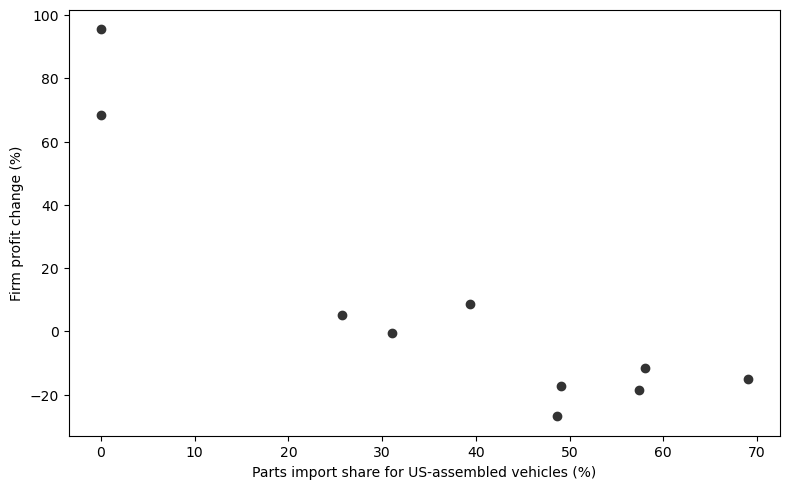

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

pc_panel = pd.read_csv("data/raw/pc_data_panel.csv")
pc_panel["product_ids"] = pc_panel["product_ids"].astype(str)
pc_panel_2024 = pc_panel.loc[pc_panel["year"] == 2024].copy()

scenario_key = next(
    k for k, s in specs.items()
    if s.parts_tariff > 0 and s.vehicle_tariff > 0 and not s.subsidy_zero
)
out_pv = outs[scenario_key]["out"]
firm_tbl = out_pv["firm_table"].copy()
firm_tbl["pct_change_profit"] = 100.0 * firm_tbl["dpi_millions_usd"] / firm_tbl["pi0_millions_usd"]

pt = out_pv["product_table"].copy()
if "plant_country" in pt.columns:
    pt = pt.drop(columns=["plant_country", "firm_ids"])
pd_map = product_data[["market_ids", "product_ids", "firm_ids", "plant_country"]].drop_duplicates()
m = pt.merge(pd_map, on=["market_ids", "product_ids"], how="left")
if "plant_country" not in m.columns:
    raise KeyError("plant_country not found after merge")
m = m[m["plant_country"].astype(str).str.strip().eq("United States")].copy()

pc_map = costs_df2[["product_ids", "pcUSCA_pct"]].drop_duplicates("product_ids")
m = m.merge(pc_map, on="product_ids", how="left")
m["import_share"] = 1.0 - pd.to_numeric(m["pcUSCA_pct"], errors="coerce")

w = m["s0"].to_numpy(dtype=float)
m["w"] = w
firm_import = (
    m.groupby("firm_ids", dropna=False)
     .apply(lambda d: np.nan if d["w"].sum() == 0 else np.nansum(d["import_share"] * d["w"]) / np.nansum(d["w"]))
     .reset_index(name="import_share")
)

plot_df = firm_tbl.merge(firm_import, on="firm_ids", how="inner")
plot_df = plot_df[np.isfinite(plot_df["import_share"])].copy()
plot_df["import_share_pct"] = 100.0 * plot_df["import_share"]
plot_df["is_us"] = plot_df["firm_ids"].astype(str).str.lower().isin(us_set)
plot_df = plot_df[plot_df["is_us"]].copy()
plot_df = plot_df[~plot_df["firm_ids"].astype(str).str.lower().eq("rivian")].copy()

us_firm_ids = sorted(plot_df.loc[plot_df["is_us"], "firm_ids"].astype(str).unique())
print("US firms in chart:", us_firm_ids)

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(plot_df["import_share_pct"], plot_df["pct_change_profit"], color="0.2")
for _, r in plot_df.iterrows():
    ax.annotate(
        str(r["firm_ids"]),
        (r["import_share_pct"], r["pct_change_profit"]),
        textcoords="offset points",
        xytext=(4, 2),
        ha="left",
        fontsize=8,
        color="black",
    )

x = plot_df["import_share_pct"].to_numpy(dtype=float)
y = plot_df["pct_change_profit"].to_numpy(dtype=float)
mask = np.isfinite(x) & np.isfinite(y)
# if mask.sum() >= 2:
#     coef = np.polyfit(x[mask], y[mask], 1)
#     xs = np.linspace(x[mask].min(), x[mask].max(), 100)
#     ys = coef[0] * xs + coef[1]
#     ax.plot(xs, ys, color="tab:blue", linewidth=1.5)

#ax.axhline(0, color="black", linewidth=0.5)
ax.set_xlabel("Parts import share for US-assembled vehicles (%)")
ax.set_ylabel("Firm profit change (%)")
plt.tight_layout()
fig.savefig(os.path.join(output_dir, "profit_change_vs_import_share.png"), dpi=200, bbox_inches="tight")
plt.show()


In [61]:
# Top 5 price increases: vehicles-only tariff (with subsidy)
key_vo = next(
    k for k, s in specs.items()
    if s.parts_tariff == 0 and s.vehicle_tariff > 0 and not s.subsidy_zero
)
pt = outs[key_vo]["out"]["product_table"].copy()
pt = pt.sort_values("dp_pct", ascending=False).head(5)
cols = [c for c in ["product_ids", "dp_pct", "p0", "p_cf"] if c in pt.columns]
display(pt[cols])


,product_ids,dp_pct,p0,p_cf
29,2024_bmw_2seriesm,17.596843,0.375483,0.441556
32,2024_bmw_3seriesm,17.358158,0.450277,0.528437
34,2024_bmw_4seriesm,17.267128,0.476342,0.558593
194,2024_lexus_rxhybrid,17.165658,0.433014,0.507344
44,2024_bmw_m3,17.087951,0.605910,0.709448


In [60]:
# Top 5 price increases: vehicles-only tariff (with subsidy), US-assembled
key_vo = next(
    k for k, s in specs.items()
    if s.parts_tariff == 0 and s.vehicle_tariff > 0 and not s.subsidy_zero
)
pt = outs[key_vo]["out"]["product_table"].copy()
if "plant_country" in pt.columns:
    pt = pt.drop(columns=["plant_country"])
pd_map = product_data[["market_ids", "product_ids", "plant_country"]].drop_duplicates()
m = pt.merge(pd_map, on=["market_ids", "product_ids"], how="left")
m = m[m["plant_country"].astype(str).str.strip().eq("United States")].copy()
m = m.sort_values("dp_pct", ascending=False).head(5)
cols = [c for c in ["product_ids", "dp_pct", "p0", "p_cf"] if c in m.columns]
display(m[cols])


,product_ids,plant_location,dp_pct,p0,p_cf
0,2024_bmw_2seriesm,Mexico,17.596843,0.375483,0.441556
1,2024_bmw_3seriesm,Mexico,17.358158,0.450277,0.528437
2,2024_bmw_4seriesm,Germany,17.267128,0.476342,0.558593
3,2024_lexus_rxhybrid,Canada,17.165658,0.433014,0.507344
4,2024_bmw_m3,Germany,17.087951,0.605910,0.709448


## Division Map (Derived from Agent Data)
This map assigns each state to the division with the highest average division dummy in the agent data.


In [132]:
import numpy as np
import pandas as pd
try:
    import plotly.graph_objects as go
except ImportError:
    go = None

source_df = None
if 'agent_cf' in globals():
    source_df = agent_cf.copy()
elif 'agent_data' in globals():
    source_df = agent_data.copy()

if source_df is None:
    print('agent_cf/agent_data not available; cannot build division map.')
elif go is None:
    print('Plotly is required for the division map.')
else:
    div_cols = [c for c in source_df.columns if c.lower().startswith('div') and c[3:].isdigit()]
    if not div_cols:
        raise ValueError('No division columns found (expected div1..div6).')

    state_raw = source_df['state'].astype(str).str.strip()
    state_key = np.where(state_raw.str.len() == 2, state_raw.str.upper(), state_raw.str.title())
    state_abbr_map = pd.Series(STATE_ABBR)
    state_abbr = np.where(pd.Series(state_key).str.len() == 2, state_key, pd.Series(state_key).map(state_abbr_map))
    state_abbr = pd.Series(state_abbr)

    df = source_df.copy()
    df['state_abbr'] = state_abbr.values
    df = df.dropna(subset=['state_abbr'])

    div_means = df.groupby('state_abbr', dropna=False)[div_cols].mean()
    div_idx = div_means.to_numpy().argmax(axis=1) + 1
    div_map = pd.DataFrame({
        'state_abbr': div_means.index,
        'division_id': div_idx,
    })

    div_labels = ['North East', 'North Central', 'South Atlantic', 'South Central', 'Mountain', 'Pacific']
    palette = plotly.colors.qualitative.Set2
    colors = palette[:len(div_labels)]
    scale = []
    if len(colors) == 1:
        scale = [[0.0, colors[0]], [1.0, colors[0]]]
    else:
        for i, c in enumerate(colors):
            scale.append([i / (len(colors) - 1), c])

    fig = go.Figure(go.Choropleth(
        locations=div_map['state_abbr'],
        z=div_map['division_id'],
        locationmode='USA-states',
        colorscale=scale,
        showscale=False,
        marker_line_color='white',
        marker_line_width=0.5,
    ))

    # Legend entries for divisions
    for label, color in zip(div_labels, colors):
        fig.add_trace(go.Scattergeo(
            lon=[None],
            lat=[None],
            mode='markers',
            marker=dict(size=10, color=color),
            name=label,
            showlegend=True,
        ))

    # State labels
    labels = []
    for s in div_map['state_abbr']:
        if s in STATE_CENTROIDS:
            lat, lon = STATE_CENTROIDS[s]
            labels.append((s, lat, lon))
    if labels:
        fig.add_trace(go.Scattergeo(
            lon=[x[2] for x in labels],
            lat=[x[1] for x in labels],
            text=[x[0] for x in labels],
            mode='text',
            textposition='bottom center',
            textfont=dict(size=10, color='black'),
            showlegend=False,
        ))

    fig.update_layout(
        title='US Divisions (Derived from Agent Data)',
        geo_scope='usa',
        margin={'r': 0, 't': 40, 'l': 0, 'b': 0},
        width=1100,
        height=700,
        legend=dict(
            x=0.86,
            y=0.98,
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='rgba(0,0,0,0.1)',
            borderwidth=1,
            font=dict(size=11),
        ),
    )
    fig.update_geos(
        projection_scale=1.05,
        showframe=False,
        showcountries=False,
        showcoastlines=False,
    )
    fig



NameError: name 'plotly' is not defined

,product_ids,make_model,year,plant_country,pcUSCA_pct
0,2016_acura_ilx,acura_ilx,2016,United States,0.600
1,2016_acura_mdx,acura_mdx,2016,United States,0.650
2,2016_acura_rdx,acura_rdx,2016,United States,0.700
3,2016_acura_tlx,acura_tlx,2016,United States,0.650
4,2016_bmw_x3,bmw_x3,2016,United States,0.100
...,...,...,...,...,...
685,2024_volkswagen_atlas,volkswagen_atlas,2024,United States,0.495
686,2024_volkswagen_atlascrosssport,volkswagen_atlascrosssport,2024,United States,0.490
687,2024_volkswagen_id4ev,volkswagen_id4ev,2024,United States,0.710
688,2024_volvo_s60,volvo_s60,2024,United States,0.300


## Full State × Scenario Utility Change Table
Print the full state-by-scenario CS change table with all rows visible.


In [ ]:
import pandas as pd

if 'cs_tbl' in globals():
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(cs_tbl)
else:
    print('cs_tbl not found; run the full outputs cell first.')
